## Reinforcement Learning Assignment

### By Tushar Prasad


You need to accomplish following in this assignment:

Create an MDP for Numerical Tic-Tac-Toe game. The basic framework for this is:

Initialise the state

Define the action space for each state. (Be careful in defining actions. The actions are not the same for each state)

Define the winning states: the sum of three numbers in a row, column or diagonal is 15.

Define the terminal states (win,tie,loss)

Build the reward structure as below:

+10 if the agent wins (makes 15 points first)

-10 if the environment wins

0 if the game ends in a draw (no one is able to make 15 and the board is filled up)

-1 for each move agent takes

Define a step function which takes in an input of the agent’s action and state; and outputs the next state and reward. (Make sure you incorporate environment’s move in the next state).

For your reference: TCGame_Env.py file is provided with a basic structure of the code. The functions (and the comments) will provide an intuition of how the MDP would be formulated. Codes of a few functions are also provided to give you more sense on how to proceed with the MDP. Note: Using this framework is not compulsory, you can create your own framework and functions as well.

Build an agent that learns the game by Q-Learning. You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor) of your choice. For that, you can train the model iteratively to obtain a good combination of hyperparameters. You won’t be evaluated on your choice of the hyperparameters. You need to submit only the final model. 

While updating the Q-values, if the next state is a terminal state, then the Q-values from that state are 0. (No action is possible from that state)

For a 64-bit system with 8GB RAM, it takes ~30 minutes to run 5Mn episodes.

Q-values convergence- check whether Q-values learnt by the agent have converged or not. Sample 4 state-action pairs and plot it with the number of episodes to understand the convergence.

## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe

import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

###### -------please call your environment as env
env = TicTacToe()

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = random.sample(valid_actions(state),1)[0]     #Exploration: randomly choosing and action
    
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)


# For retraining with already trained Policy learned
with open('Q_values.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)
      

with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)   


In [103]:
# Initialise states to be tracked
  
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(3,5)),('x-3-x-x-x-2-x-x-x',(5,1)),
                       ('x-5-x-x-2-x-x-x-x',(7,3)),('x-x-x-x-x-x-x-x-x',(0,5))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  #this is an array which will have appended values of that state-action pair for every 2000th episode         
  

In [104]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [105]:
#### Saving the sample tracking state functions

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [106]:
## initialising the tracking states dict

initialise_tracking_states()

#### Define hyperparameters 

In [114]:
#Defining parameters for the training

EPISODES = 1000000
LR = 0.05                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.003        # epsilon decay rate
threshold = 100       # no of episodes after which states_tracked wwill be saved
policy_threshold = 200   # no of episodes after which Q dictionary/table will be saved

### Q-update loop 

In [56]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe() # call the environment
    done = False
    curr_state = env.state    
    add_to_dict(curr_state)  # adding the current state to dictionary
    reward=0
    total_reward = 0
    
    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting reward
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)
        
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))
            
         # navigating to next state
        curr_state = next_state
        total_reward += reward

         #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')
        print(episode)
#         print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
      
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Q_values')

print('Total Execution time: ', elapsed_time)

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499
4599
4699
4799
4899
4999
5099
5199
5299
5399
5499
5599
5699
5799
5899
5999
6099
6199
6299
6399
6499
6599
6699
6799
6899
6999
7099
7199
7299
7399
7499
7599
7699
7799
7899
7999
8099
8199
8299
8399
8499
8599
8699
8799
8899
8999
9099
9199
9299
9399
9499
9599
9699
9799
9899
9999
10099
10199
10299
10399
10499
10599
10699
10799
10899
10999
11099
11199
11299
11399
11499
11599
11699
11799
11899
11999
12099
12199
12299
12399
12499
12599
12699
12799
12899
12999
13099
13199
13299
13399
13499
13599
13699
13799
13899
13999
14099
14199
14299
14399
14499
14599
14699
14799
14899
14999
15099
15199
15299
15399
15499
15599
15699
15799
15899
15999
16099
16199
16299
16399
16499
16599
16699
16799
16899
16999
17099
17199
17299
17399
17499
17599
17699
17799
17899
17999
18099
18199
18299
18399
18499
1

133099
133199
133299
133399
133499
133599
133699
133799
133899
133999
134099
134199
134299
134399
134499
134599
134699
134799
134899
134999
135099
135199
135299
135399
135499
135599
135699
135799
135899
135999
136099
136199
136299
136399
136499
136599
136699
136799
136899
136999
137099
137199
137299
137399
137499
137599
137699
137799
137899
137999
138099
138199
138299
138399
138499
138599
138699
138799
138899
138999
139099
139199
139299
139399
139499
139599
139699
139799
139899
139999
140099
140199
140299
140399
140499
140599
140699
140799
140899
140999
141099
141199
141299
141399
141499
141599
141699
141799
141899
141999
142099
142199
142299
142399
142499
142599
142699
142799
142899
142999
143099
143199
143299
143399
143499
143599
143699
143799
143899
143999
144099
144199
144299
144399
144499
144599
144699
144799
144899
144999
145099
145199
145299
145399
145499
145599
145699
145799
145899
145999
146099
146199
146299
146399
146499
146599
146699
146799
146899
146999
147099
147199
147299

250299
250399
250499
250599
250699
250799
250899
250999
251099
251199
251299
251399
251499
251599
251699
251799
251899
251999
252099
252199
252299
252399
252499
252599
252699
252799
252899
252999
253099
253199
253299
253399
253499
253599
253699
253799
253899
253999
254099
254199
254299
254399
254499
254599
254699
254799
254899
254999
255099
255199
255299
255399
255499
255599
255699
255799
255899
255999
256099
256199
256299
256399
256499
256599
256699
256799
256899
256999
257099
257199
257299
257399
257499
257599
257699
257799
257899
257999
258099
258199
258299
258399
258499
258599
258699
258799
258899
258999
259099
259199
259299
259399
259499
259599
259699
259799
259899
259999
260099
260199
260299
260399
260499
260599
260699
260799
260899
260999
261099
261199
261299
261399
261499
261599
261699
261799
261899
261999
262099
262199
262299
262399
262499
262599
262699
262799
262899
262999
263099
263199
263299
263399
263499
263599
263699
263799
263899
263999
264099
264199
264299
264399
264499

367499
367599
367699
367799
367899
367999
368099
368199
368299
368399
368499
368599
368699
368799
368899
368999
369099
369199
369299
369399
369499
369599
369699
369799
369899
369999
370099
370199
370299
370399
370499
370599
370699
370799
370899
370999
371099
371199
371299
371399
371499
371599
371699
371799
371899
371999
372099
372199
372299
372399
372499
372599
372699
372799
372899
372999
373099
373199
373299
373399
373499
373599
373699
373799
373899
373999
374099
374199
374299
374399
374499
374599
374699
374799
374899
374999
375099
375199
375299
375399
375499
375599
375699
375799
375899
375999
376099
376199
376299
376399
376499
376599
376699
376799
376899
376999
377099
377199
377299
377399
377499
377599
377699
377799
377899
377999
378099
378199
378299
378399
378499
378599
378699
378799
378899
378999
379099
379199
379299
379399
379499
379599
379699
379799
379899
379999
380099
380199
380299
380399
380499
380599
380699
380799
380899
380999
381099
381199
381299
381399
381499
381599
381699

484699
484799
484899
484999
485099
485199
485299
485399
485499
485599
485699
485799
485899
485999
486099
486199
486299
486399
486499
486599
486699
486799
486899
486999
487099
487199
487299
487399
487499
487599
487699
487799
487899
487999
488099
488199
488299
488399
488499
488599
488699
488799
488899
488999
489099
489199
489299
489399
489499
489599
489699
489799
489899
489999
490099
490199
490299
490399
490499
490599
490699
490799
490899
490999
491099
491199
491299
491399
491499
491599
491699
491799
491899
491999
492099
492199
492299
492399
492499
492599
492699
492799
492899
492999
493099
493199
493299
493399
493499
493599
493699
493799
493899
493999
494099
494199
494299
494399
494499
494599
494699
494799
494899
494999
495099
495199
495299
495399
495499
495599
495699
495799
495899
495999
496099
496199
496299
496399
496499
496599
496699
496799
496899
496999
497099
497199
497299
497399
497499
497599
497699
497799
497899
497999
498099
498199
498299
498399
498499
498599
498699
498799
498899

601899
601999
602099
602199
602299
602399
602499
602599
602699
602799
602899
602999
603099
603199
603299
603399
603499
603599
603699
603799
603899
603999
604099
604199
604299
604399
604499
604599
604699
604799
604899
604999
605099
605199
605299
605399
605499
605599
605699
605799
605899
605999
606099
606199
606299
606399
606499
606599
606699
606799
606899
606999
607099
607199
607299
607399
607499
607599
607699
607799
607899
607999
608099
608199
608299
608399
608499
608599
608699
608799
608899
608999
609099
609199
609299
609399
609499
609599
609699
609799
609899
609999
610099
610199
610299
610399
610499
610599
610699
610799
610899
610999
611099
611199
611299
611399
611499
611599
611699
611799
611899
611999
612099
612199
612299
612399
612499
612599
612699
612799
612899
612999
613099
613199
613299
613399
613499
613599
613699
613799
613899
613999
614099
614199
614299
614399
614499
614599
614699
614799
614899
614999
615099
615199
615299
615399
615499
615599
615699
615799
615899
615999
616099

719099
719199
719299
719399
719499
719599
719699
719799
719899
719999
720099
720199
720299
720399
720499
720599
720699
720799
720899
720999
721099
721199
721299
721399
721499
721599
721699
721799
721899
721999
722099
722199
722299
722399
722499
722599
722699
722799
722899
722999
723099
723199
723299
723399
723499
723599
723699
723799
723899
723999
724099
724199
724299
724399
724499
724599
724699
724799
724899
724999
725099
725199
725299
725399
725499
725599
725699
725799
725899
725999
726099
726199
726299
726399
726499
726599
726699
726799
726899
726999
727099
727199
727299
727399
727499
727599
727699
727799
727899
727999
728099
728199
728299
728399
728499
728599
728699
728799
728899
728999
729099
729199
729299
729399
729499
729599
729699
729799
729899
729999
730099
730199
730299
730399
730499
730599
730699
730799
730899
730999
731099
731199
731299
731399
731499
731599
731699
731799
731899
731999
732099
732199
732299
732399
732499
732599
732699
732799
732899
732999
733099
733199
733299

836299
836399
836499
836599
836699
836799
836899
836999
837099
837199
837299
837399
837499
837599
837699
837799
837899
837999
838099
838199
838299
838399
838499
838599
838699
838799
838899
838999
839099
839199
839299
839399
839499
839599
839699
839799
839899
839999
840099
840199
840299
840399
840499
840599
840699
840799
840899
840999
841099
841199
841299
841399
841499
841599
841699
841799
841899
841999
842099
842199
842299
842399
842499
842599
842699
842799
842899
842999
843099
843199
843299
843399
843499
843599
843699
843799
843899
843999
844099
844199
844299
844399
844499
844599
844699
844799
844899
844999
845099
845199
845299
845399
845499
845599
845699
845799
845899
845999
846099
846199
846299
846399
846499
846599
846699
846799
846899
846999
847099
847199
847299
847399
847499
847599
847699
847799
847899
847999
848099
848199
848299
848399
848499
848599
848699
848799
848899
848999
849099
849199
849299
849399
849499
849599
849699
849799
849899
849999
850099
850199
850299
850399
850499

953399
953499
953599
953699
953799
953899
953999
954099
954199
954299
954399
954499
954599
954699
954799
954899
954999
955099
955199
955299
955399
955499
955599
955699
955799
955899
955999
956099
956199
956299
956399
956499
956599
956699
956799
956899
956999
957099
957199
957299
957399
957499
957599
957699
957799
957899
957999
958099
958199
958299
958399
958499
958599
958699
958799
958899
958999
959099
959199
959299
959399
959499
959599
959699
959799
959899
959999
960099
960199
960299
960399
960499
960599
960699
960799
960899
960999
961099
961199
961299
961399
961499
961599
961699
961799
961899
961999
962099
962199
962299
962399
962499
962599
962699
962799
962899
962999
963099
963199
963299
963399
963499
963599
963699
963799
963899
963999
964099
964199
964299
964399
964499
964599
964699
964799
964899
964999
965099
965199
965299
965399
965499
965599
965699
965799
965899
965999
966099
966199
966299
966399
966499
966599
966699
966799
966899
966999
967099
967199
967299
967399
967499
967599

#### Check the Q-dictionary

In [118]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2109736711400776,
              (0, 3): -1.227855414288375,
              (0, 5): -1.2203305189081322,
              (0, 7): -1.2220347569411931,
              (0, 9): -1.23456814798125,
              (1, 1): -1.2252707532511071,
              (1, 3): -1.2260798680570002,
              (1, 5): -1.2211017419953076,
              (1, 7): -1.2210996577099045,
              (1, 9): 4.946985459277891,
              (2, 1): -1.2186074663831101,
              (2, 3): -1.2215186645019882,
              (2, 5): -1.1318540841152356,
              (2, 7): -1.2344629902977775,
              (2, 9): -1.2178535336569665,
              (3, 1): -1.226211477870588,
              (3, 3): -1.226234745311822,
              (3, 5): -1.2201144167511666,
              (3, 7): -1.218871093142101,
              (3, 9): -1.2215252300430446,
              (4, 1): -1.2200753029686686,
              (4, 3): -1.2270441847360245,
              (4, 5): -

In [119]:
### finding the length of the dict

len(Q_dict)

627274

In [128]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-x-x-x-x-x-x-x-x']

{(0, 1): -1.2109736711400776,
 (0, 3): -1.227855414288375,
 (0, 5): -1.2203305189081322,
 (0, 7): -1.2220347569411931,
 (0, 9): -1.23456814798125,
 (1, 1): -1.2252707532511071,
 (1, 3): -1.2260798680570002,
 (1, 5): -1.2211017419953076,
 (1, 7): -1.2210996577099045,
 (1, 9): 4.946985459277891,
 (2, 1): -1.2186074663831101,
 (2, 3): -1.2215186645019882,
 (2, 5): -1.1318540841152356,
 (2, 7): -1.2344629902977775,
 (2, 9): -1.2178535336569665,
 (3, 1): -1.226211477870588,
 (3, 3): -1.226234745311822,
 (3, 5): -1.2201144167511666,
 (3, 7): -1.218871093142101,
 (3, 9): -1.2215252300430446,
 (4, 1): -1.2200753029686686,
 (4, 3): -1.2270441847360245,
 (4, 5): -1.2280869716614153,
 (4, 7): -1.2311004913625296,
 (4, 9): -1.229041979100045,
 (5, 1): -1.2238182001962208,
 (5, 3): -1.2285009703851144,
 (5, 5): -1.2306134695428756,
 (5, 7): -1.229188990596247,
 (5, 9): -1.2145684914311345,
 (6, 1): -1.2259409365778815,
 (6, 3): -1.2299314768501255,
 (6, 5): -1.2311845937782302,
 (6, 7): -1.23444571

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [129]:
# Write the code for plotting the graphs for state-action pairs tracked

In [122]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(3, 5): [-1.2167299782936205,
               -1.2167299782936205,
               -1.2167299782936205,
               -1.2167299782936205,
               -1.2167299782936205,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1.2204016602761283,
               -1

<function matplotlib.pyplot.show(*args, **kw)>

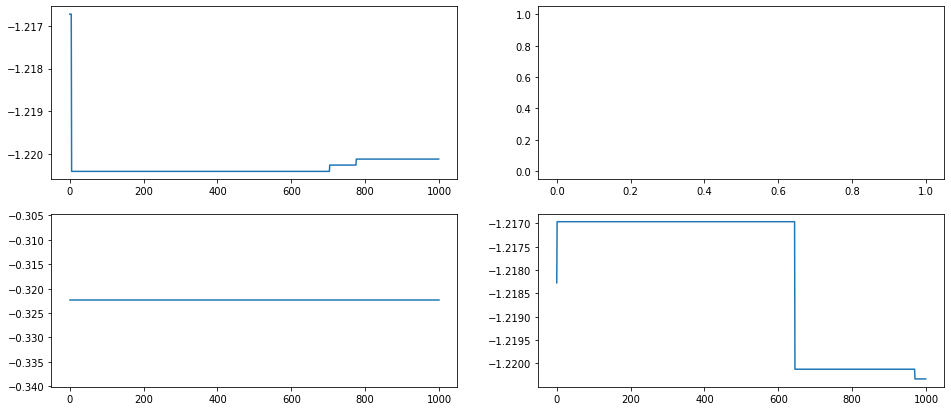

In [124]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(3,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(3,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-x-2-x-x-x'][(5,1)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-x-2-x-x-x'][(5,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-2-x-x-x-x'][(7,3)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-2-x-x-x-x'][(7,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(0,5)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(0,5)]))
plt.show

### Epsilon - decay check

In [130]:
### Finding the epsilon decay

max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,1000000)
epsilon = []
for i in range(0,1000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

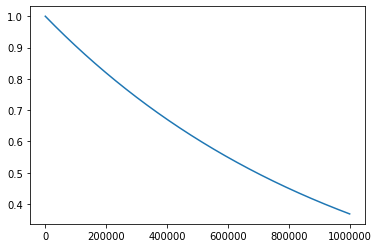

In [131]:
plt.plot(time, epsilon)
plt.show()